In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy.spatial.distance import pdist, squareform

In [5]:
def add_arrows(ax, scale, bc=0.3):
    for line in ax.get_lines():
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        for i in range(len(xdata) - 1):
            xs = xdata[i:i+2]
            ys = ydata[i:i+2]
            xm = bc*xs[0] + (1 - bc)*xs[1]
            ym = bc*ys[0] + (1 - bc)*ys[1]
            dx = xs[1] - xs[0]
            dy = ys[1] - ys[0]
            norm = np.hypot(dx, dy)
            dx = 0.01*dx/norm
            dy = 0.01*dy/norm
            ax.arrow(xm, ym, dx, dy, head_width=scale)

In [6]:
def get_distances(xs, ys):
    return squareform(pdist(np.column_stack((xs, ys))))

In [7]:
class Tour:

    def __init__(self, xs, ys, distances):
        self._xs = np.asarray(xs)
        self._ys = np.asarray(ys)
        
        self._order = np.arange(len(xs))
        self._dist = distances
        
    @property
    def xs(self):
        return self._xs[self.vertices]
    
    @property
    def ys(self):
        return self._ys[self.vertices]
    
    @property
    def length(self):
        return len(self.vertices)

    @property
    def distance(self):
        edges = self.edges
        return self._dist[edges[:, 0], edges[:, 1]].sum()
    
    @property
    def vertices(self):
        return self._order
    
    @property
    def edges(self):
        starts = self.vertices
        stops = np.roll(starts, -1)
        return np.column_stack((starts, stops))
    
#     def dist(self, v0, v1):
#         """ Compute distance between two vertices.
        
#         Vertices do not have to be adjacent.
#         """
#         ix = self._order
#         return self._dist[ix[v0 % len(ix)], ix[v1 % len(ix)]]

#     def swap(self, v0, v1):
#         """ Swap two vertices in the tour.
#         """
#         self.vertices[[v0, v1]] = self.vertices[[v1, v0]]
        
    def reverse(self, v0, v1):
        """ Reverse the orientation of the tour between v0 and v1.
        """
        r = np.arange(v0, v1)
        self.vertices[r] = self.vertices[r[::-1]]

In [8]:
class TwoOpt:
    """ A two-opt move on edges e0 and e1.
    
    If e0 = (A, B) and e1 = (C, D), the effect of this move
    is to delete the edges e0 and e1, and replace them by
    edges f0 = (A, C) and f1 = (B, D). As part of this move,
    the direction of the tour between B and C is reversed.
  
    """
    
    def __init__(self, tour, i, j):
        self._tour = tour
        n = tour.length
        self.i = i
        self.j = j
 
        v0 = tour.vertices[i]
        v1 = tour.vertices[(i+1)%n]
        w0 = tour.vertices[j]
        w1 = tour.vertices[(j+1)%n]

        before = tour._dist[v0, v1] + tour._dist[w0, w1]
        after = tour._dist[v0, w0] + tour._dist[v1, w1]
        self.gain = after - before

    def apply(self):
        n = self._tour.length
        self._tour.reverse((self.i+1)%n, (self.j+1)%n)
        
    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots()
            
        i = self.i
        j = self.j
 
        tour = self._tour
        n = tour.length
        v0 = tour.vertices[i]
        v1 = tour.vertices[(i+1)%n]
        w0 = tour.vertices[j]
        w1 = tour.vertices[(j+1)%n]

        ax.plot(tour._xs[[v0, v1]], tour._ys[[v0, v1]], color="yellow")
        ax.plot(tour._xs[[w0, w1]], tour._ys[[w0, w1]], color="yellow")
        
    def __repr__(self):
        return f"<TwoOpt(gain={self.gain}, i={self.i}, j={self.j})>" 

In [9]:
def plot_tour(tour, ax=None, title=None, arrows=True):
    if ax is None:
        _, ax = plt.subplots()
    axs = np.hstack([tour.xs, tour.xs[0]])
    ays = np.hstack([tour.ys, tour.ys[0]])
    ax.plot(axs, ays)
    ax.plot(tour.xs, tour.ys, 'ro')
    for i, x, y in zip(tour.vertices, tour.xs, tour.ys):
        ax.annotate(i, (x, y))
    if arrows:
        add_arrows(ax, 0.05)
    if title is None:
        title = f"d = {tour.distance:.03f}"
    ax.set_title(title)

In [10]:
prng = np.random.RandomState(seed=12345)

xs = prng.uniform(size=20)
ys = prng.uniform(size=20)

xs = np.array([1, 2, 3, 4, 4, 3, 2, 1])
ys = np.array([2, 2, 2, 2, 1, 1, 1, 1])

dist = get_distances(xs, ys)

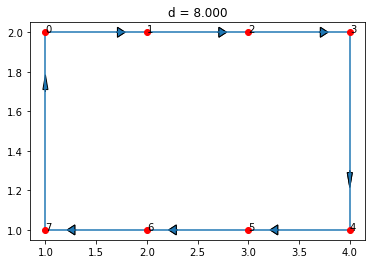

In [11]:
t = Tour(xs, ys, dist)
plot_tour(t)

In [12]:
move = TwoOpt(t, 1, 5)

In [13]:
move.gain

0.8284271247461903

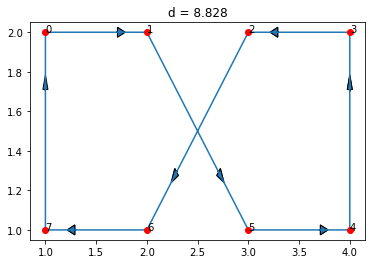

In [14]:
move.apply()
plot_tour(t)

In [15]:
def get_best_two_opt(tour):
    moves = (
        TwoOpt(tour, i, j)
        for i in range(0, tour.length)
        for j in range(i+2, tour.length)
    )
    return min(moves, key=lambda move: move.gain)         

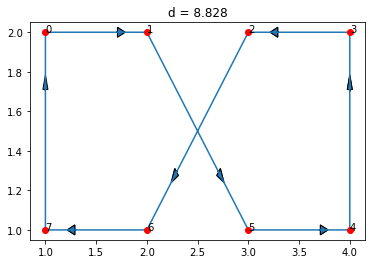

In [16]:
tour = Tour(xs, ys, dist)
move = TwoOpt(tour, 1, 5)
move.apply()
plot_tour(tour)

In [17]:
opt = get_best_two_opt(tour)

In [18]:
opt

<TwoOpt(gain=-0.8284271247461903, i=1, j=5)>

In [19]:
prng = np.random.RandomState(seed=12345)

xs = prng.uniform(size=20)
ys = prng.uniform(size=20)

dist = get_distances(xs, ys)

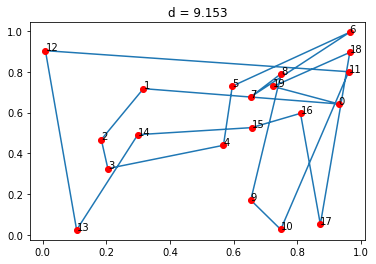

In [20]:
tour = Tour(xs, ys, dist)
plot_tour(tour, arrows=False)

In [21]:
opt = get_best_two_opt(tour)

In [22]:
opt

<TwoOpt(gain=-1.42890996915387, i=10, j=17)>

In [23]:
def plot_edges(ax, xs, ys, **kwds):
    ax.plot(xs, ys, **kwds)
    ax.plot(xs, ys, 'ro')
    ax.set_axis_off()

In [24]:
def plot_tour(ax, tour):
    xs = np.hstack((tour.xs, tour.xs[0]))
    ys = np.hstack((tour.ys, tour.ys[0]))
    plot_edges(ax, xs, ys, color="gray")

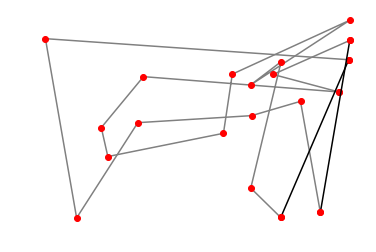

In [25]:
def plot_two_opt_before(ax, tour, opt):
    i, j = opt.i, opt.j
    if i > j:
        i, j = j, i

    xs = np.hstack((tour.xs, tour.xs[0]))
    ys = np.hstack((tour.ys, tour.ys[0]))

    plot_edges(ax, xs[:i+1], ys[:i+1], color="gray")
    plot_edges(ax, xs[i+1:j+1], ys[i+1:j+1], color="gray")
    plot_edges(ax, xs[j+1:], ys[j+1:], color="gray")

    plot_edges(ax, xs[i:i+2], ys[i:i+2], color="black")
    plot_edges(ax, xs[j:j+2], ys[j:j+2], color="black")


fig, ax = plt.subplots()
plot_two_opt_before(ax, tour, opt)

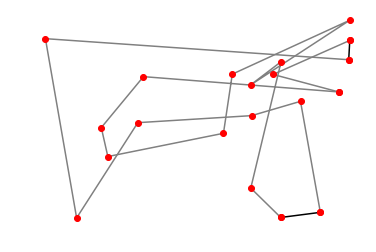

In [26]:
def plot_two_opt_after(ax, tour, opt):
    i, j = opt.i, opt.j
    if i > j:
        i, j = j, i

    xs = np.hstack((tour.xs, tour.xs[0]))
    ys = np.hstack((tour.ys, tour.ys[0]))

    plot_edges(ax, xs[:i+1], ys[:i+1], color="gray")
    plot_edges(ax, xs[i+1:j+1], ys[i+1:j+1], color="gray")
    plot_edges(ax, xs[j+1:], ys[j+1:], color="gray")

    plot_edges(ax, (xs[i], xs[j]), (ys[i], ys[j]), color="black")
    plot_edges(ax, (xs[i+1], xs[j+1]), (ys[i+1], ys[j+1]), color="black")

    
fig, ax = plt.subplots()
plot_two_opt_after(ax, tour, opt)

In [27]:
def plot_before_after(axes, tour, opt):
    plot_tour(axes[0], tour)
    plot_two_opt_before(axes[1], tour, opt)
    plot_two_opt_after(axes[2], tour, opt)

In [46]:
tour = Tour(xs, ys, dist)

<TwoOpt(gain=-1.42890996915387, i=10, j=17)>


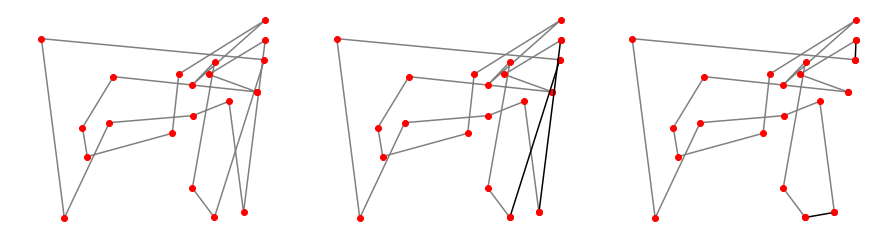

In [47]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.6063101475099947, i=5, j=16)>


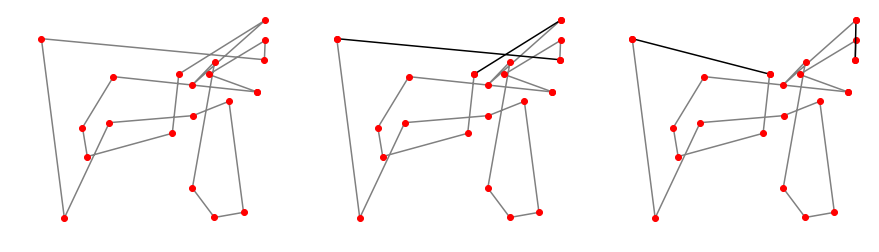

In [48]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.5250108995254876, i=0, j=5)>


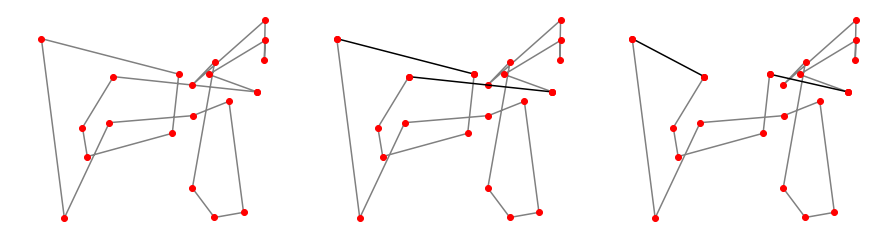

In [49]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.26939063361577287, i=13, j=15)>


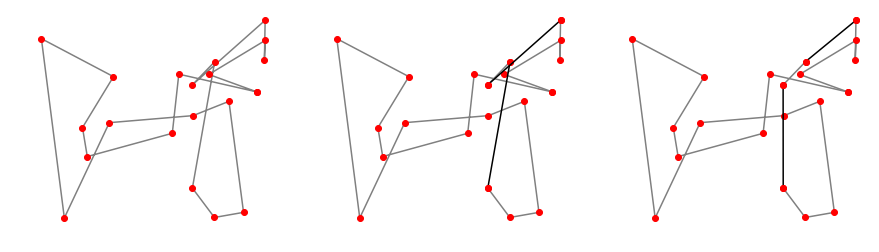

In [50]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.25516251944132634, i=0, j=18)>


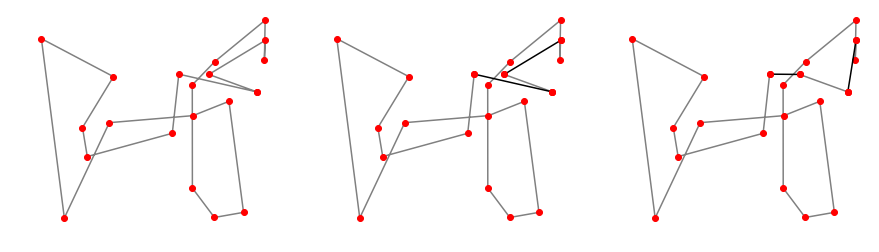

In [51]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.23627727684635635, i=5, j=10)>


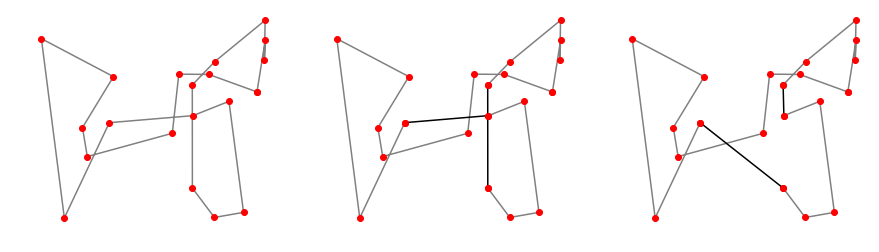

In [52]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.2925729290910841, i=10, j=12)>


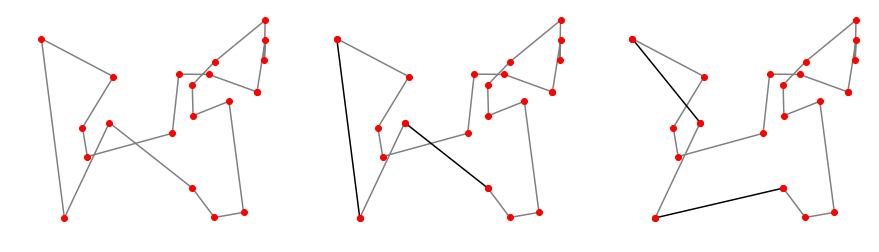

In [53]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.2952272551598357, i=11, j=16)>


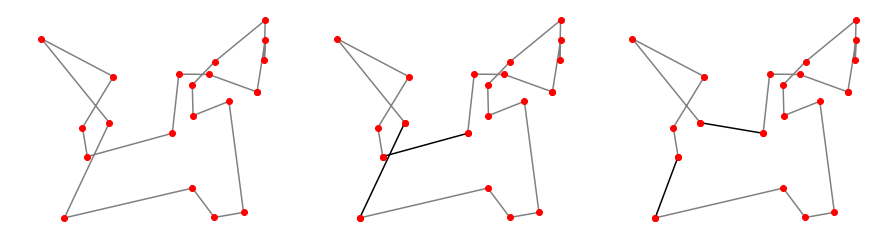

In [54]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.18873362060236543, i=0, j=2)>


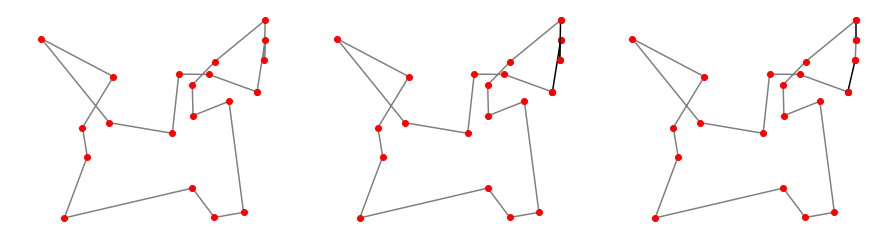

In [55]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.09026505272954055, i=13, j=15)>


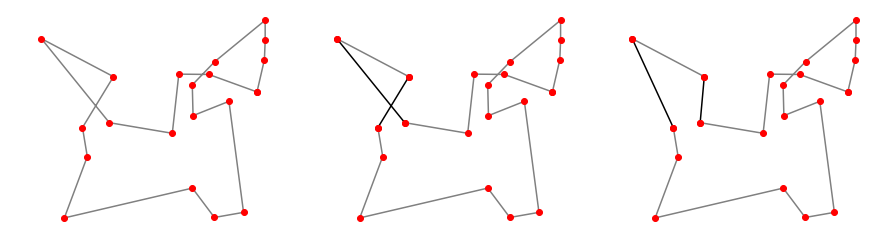

In [56]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.083716936989566, i=6, j=17)>


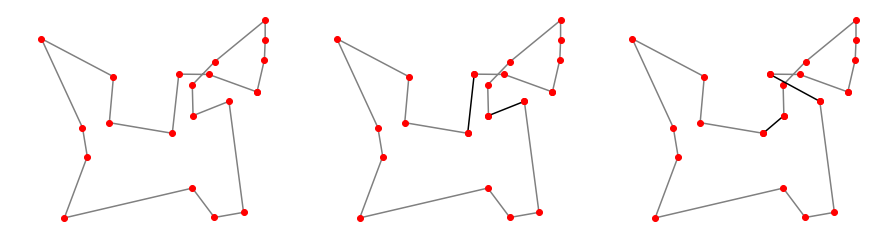

In [57]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.11923979929931322, i=4, j=17)>


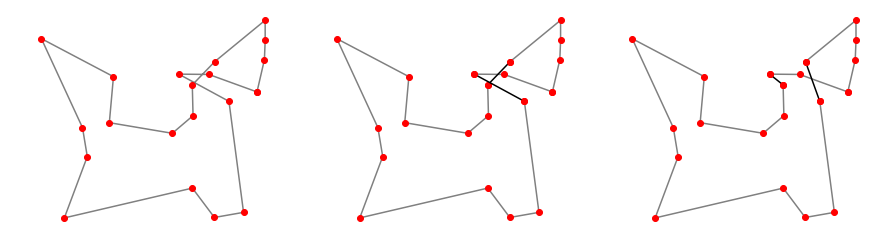

In [58]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.23103830098681125, i=4, j=19)>


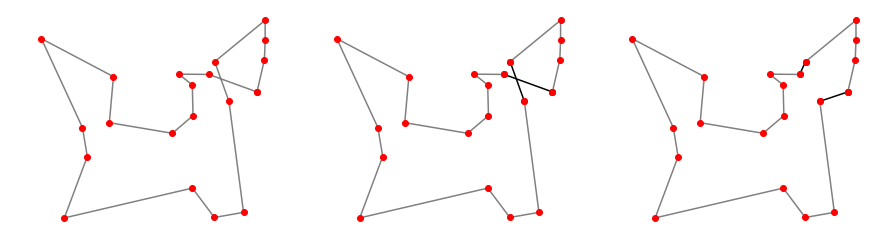

In [59]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

<TwoOpt(gain=-0.23103830098681125, i=4, j=19)>


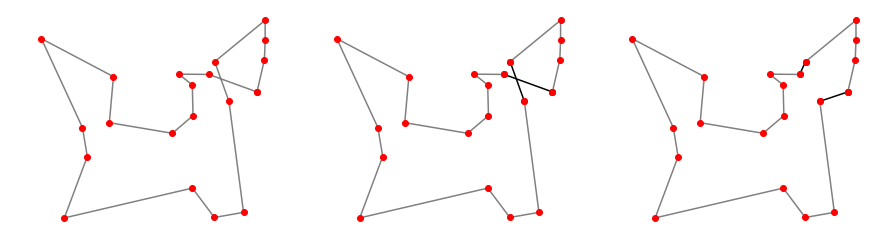

In [60]:
opt = get_best_two_opt(tour)
print(opt)

if opt.gain < 0:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    plot_before_after(axes, tour, opt)

    opt.apply()

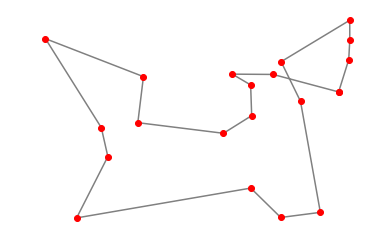

In [62]:
_, ax = plt.subplots()
plot_tour(ax, tour)

In [63]:
opt

<TwoOpt(gain=-0.23103830098681125, i=4, j=19)>